In [1]:
SEED = 42
PYTORCH_PRETRAINED_BERT_CACHE = "/Users/julian/hackzurich/temp"

In [79]:
# Local network environment settings
import os
os.environ["http_proxy"] = "127.0.0.1:11233"
os.environ["https_proxy"] = "127.0.0.1:11233"

In [80]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")

In [81]:
import json
import gc
import sys
sys.path.insert(0, '../')

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert_2.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert_2.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

## Data Preparation

In [134]:
with open("/Users/julian/hackzurich/trial1/isocial.json") as fin:
    dat = json.load(fin)

entries = []
for i in dat['hits']['hits']:
   src = i['_source']
   if 'title' in src and 'snippet' in src:
       entries.append((src['title'],src['snippet'], src['company_codes'], src['industry_codes'], src['region_codes'], src['publication_date']))

In [135]:
df_full = pd.DataFrame([{"title": x[0], "desc": x[1], "company_codes": x[2], 'industry_codes': x[3], 'region_codes': x[4], 'publication_date': x[5]} for x in entries])
df_full.desc.str.len().describe()

count    990.000000
mean     414.140404
std      217.787991
min       24.000000
25%      259.250000
50%      376.000000
75%      527.500000
max      994.000000
Name: desc, dtype: float64

In [136]:
print(df_full.shape)
print(df_full.shape[0], df_full[df_full.desc.str.len() >= 10].shape[0], df_full[df_full.desc.str.len() > 200].shape[0])

(990, 6)
990 990 840


In [137]:
df_full = df_full[df_full.desc.str.len() >= 10].copy()

In [126]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [ ]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [ ]:
def convert_sentence_pair(titles, descs, max_seq_length, tokenizer):
    features = []
    for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
        tokens_a = tokenizer.tokenize(title)

        tokens_b = None
        tokens_b = tokenizer.tokenize(desc)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1
        ))
    return features

In [91]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir='PYTORCH_PRETRAINED_BERT_CACHE')

09/28/2019 10:21:48 - INFO - pytorch_pretrained_bert_2.tokenization -   loading vocabulary file /Users/julian/hackzurich/bert-base-uncased-vocab.txt


In [130]:
correct_pairs = convert_sentence_pair(df_full.title.tolist(), df_full.desc.tolist(), max_seq_length=200, tokenizer=tokenizer)

09/28/2019 13:32:58 - INFO - bert -   *** Example ***
09/28/2019 13:32:58 - INFO - bert -   tokens: [CLS] o ’ neill slams twitter draw fix all ##ega ##tion ; gaa chief liam o ’ neill has declared war on twitter . [SEP] president o ’ neill has warned inter - county players about t ##wee ##ts alleging that cr ##oke park rigged the qualifier draw so ca ##van would meet kildare . the second - round draw was made by o ’ neill and former meath player liam hayes live on tv ##3 on monday morning . [SEP]
09/28/2019 13:32:58 - INFO - bert -   input_ids: 101 1051 1521 11511 25967 10474 4009 8081 2035 29107 3508 1025 19930 2708 8230 1051 1521 11511 2038 4161 2162 2006 10474 1012 102 2343 1051 1521 11511 2038 7420 6970 1011 2221 2867 2055 1056 28394 3215 23294 2008 13675 11045 2380 25216 1996 10981 4009 2061 6187 6212 2052 3113 24275 1012 1996 2117 1011 2461 4009 2001 2081 2011 1051 1521 11511 1998 2280 26856 2447 8230 10192 2444 2006 2694 2509 2006 6928 2851 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

09/28/2019 13:32:58 - INFO - bert -   input_ids: 101 16950 9102 4059 15795 4848 102 3190 1024 4214 1996 2553 1037 1000 11655 10431 1998 25506 9861 1000 1010 9130 3910 2928 16950 9102 4059 9720 1037 2976 2457 2000 19776 1037 9870 2011 1037 2047 2259 2158 6815 2002 8617 1037 4121 8406 1999 9130 1012 1999 1037 15242 2007 1996 2149 2212 2457 1999 2047 2259 1010 9130 4297 1998 16950 9102 4059 2056 1996 9870 2011 2703 8292 20011 2003 2241 2006 1037 1000 3460 2098 3206 1998 24212 3350 1000 1012 2027 2036 2170 1996 20579 1000 2019 1999 19510 22139 8040 3286 3063 3005 23337 8908 2408 5109 1998 6645 1000 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/28/2019 13:32:58 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [93]:
len(correct_pairs)

990

## Model

In [94]:
print(PYTORCH_PRETRAINED_BERT_CACHE)
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

09/28/2019 10:21:59 - INFO - pytorch_pretrained_bert_2.modeling -   loading archive file /Users/julian/hackzurich/bert-base-uncased.tar.gz
09/28/2019 10:21:59 - INFO - pytorch_pretrained_bert_2.modeling -   extracting archive file /Users/julian/hackzurich/bert-base-uncased.tar.gz to temp dir /var/folders/2w/1m5pt0y15v9b52t33h6_4ksr0000gn/T/tmpxxounxve


/Users/julian/hackzurich/temp


09/28/2019 10:22:02 - INFO - pytorch_pretrained_bert_2.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



yooooooo
/var/folders/2w/1m5pt0y15v9b52t33h6_4ksr0000gn/T/tmpxxounxve/bert_config.json


09/28/2019 10:22:05 - INFO - pytorch_pretrained_bert_2.modeling -   Weights from pretrained model not used in BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


## Eval Correct Pairs

In [95]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

09/28/2019 10:22:16 - INFO - bert -   ***** Running evaluation *****
09/28/2019 10:22:16 - INFO - bert -     Num examples = 990
09/28/2019 10:22:16 - INFO - bert -     Batch size = 128


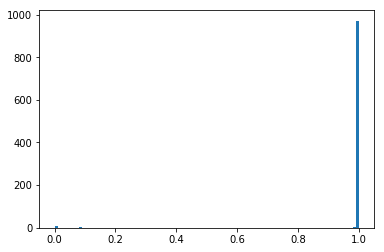

In [96]:
_ = plt.hist(res, bins=100)

In [97]:
sum(res > 0.99) / len(res), sum(res > 0.9) / len(res), sum(res < 0.5) / len(res)

(0.9808080808080808, 0.9838383838383838, 0.01616161616161616)

In [107]:
len(np.where(res < 0.5)[0])

16

In [102]:
idx = 141
df_full.iloc[idx].title, df_full.iloc[idx].desc

('21st century revolution',
 'On the first day of mass protests in Egypt, the government of Hosni Mubarak shut down all Internet Service Providers, or ISPs, an unprecedented step in a country with a fairly evolved Internet ecosystem. The rationale behind the decision, one understands, was to prevent the use of Twitter, Facebook and other social networks. One reason obviously was to prevent the use of these sites to organise rallies. The second, and this is possibly more insidious, was to prevent the use of such platforms to get news out of Egypt.')

## Find similar entries

In [103]:
df_full.iloc[102].to_dict()

{'desc': 'PALO ALTO, Calif. — For months, Facebook was uncharacteristically quiet about its membership growth. Whispers among those who closely follow the social-networking giant reached full-throated debate a few weeks ago, with word that Facebook’s numbers were down in the U.S. and several other countries.\n\nBut Wednesday, the company broke its silence and announced it had passed 750 million worldwide members who post billions of messages each day.',
 'title': 'Facebook passes 750 million members'}

In [109]:
idx = 102
sentence_pairs = convert_sentence_pair(
    [df_full.iloc[idx]["title"]] * df_full.shape[0], 
    df_full.desc.tolist(), max_seq_length=200, tokenizer=tokenizer)
df_full.iloc[idx].title, df_full.iloc[idx].desc

09/28/2019 10:37:36 - INFO - bert -   *** Example ***
09/28/2019 10:37:36 - INFO - bert -   tokens: [CLS] facebook passes 750 million members [SEP] president o ’ neill has warned inter - county players about t ##wee ##ts alleging that cr ##oke park rigged the qualifier draw so ca ##van would meet kildare . the second - round draw was made by o ’ neill and former meath player liam hayes live on tv ##3 on monday morning . [SEP]
09/28/2019 10:37:36 - INFO - bert -   input_ids: 101 9130 5235 9683 2454 2372 102 2343 1051 1521 11511 2038 7420 6970 1011 2221 2867 2055 1056 28394 3215 23294 2008 13675 11045 2380 25216 1996 10981 4009 2061 6187 6212 2052 3113 24275 1012 1996 2117 1011 2461 4009 2001 2081 2011 1051 1521 11511 1998 2280 26856 2447 8230 10192 2444 2006 2694 2509 2006 6928 2851 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

09/28/2019 10:37:36 - INFO - bert -   input_ids: 101 9130 5235 9683 2454 2372 102 3190 1024 4214 1996 2553 1037 1000 11655 10431 1998 25506 9861 1000 1010 9130 3910 2928 16950 9102 4059 9720 1037 2976 2457 2000 19776 1037 9870 2011 1037 2047 2259 2158 6815 2002 8617 1037 4121 8406 1999 9130 1012 1999 1037 15242 2007 1996 2149 2212 2457 1999 2047 2259 1010 9130 4297 1998 16950 9102 4059 2056 1996 9870 2011 2703 8292 20011 2003 2241 2006 1037 1000 3460 2098 3206 1998 24212 3350 1000 1012 2027 2036 2170 1996 20579 1000 2019 1999 19510 22139 8040 3286 3063 3005 23337 8908 2408 5109 1998 6645 1000 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/28/2019 10:37:36 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

('Facebook passes 750 million members',
 'PALO ALTO, Calif. — For months, Facebook was uncharacteristically quiet about its membership growth. Whispers among those who closely follow the social-networking giant reached full-throated debate a few weeks ago, with word that Facebook’s numbers were down in the U.S. and several other countries.\n\nBut Wednesday, the company broke its silence and announced it had passed 750 million worldwide members who post billions of messages each day.')

In [110]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

09/28/2019 10:37:46 - INFO - bert -   ***** Running evaluation *****
09/28/2019 10:37:46 - INFO - bert -     Num examples = 990
09/28/2019 10:37:46 - INFO - bert -     Batch size = 128


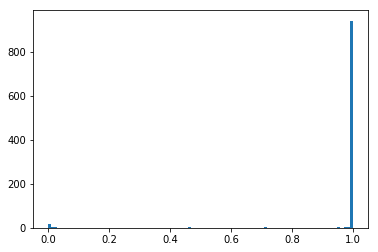

In [111]:
_ = plt.hist(res, bins=100)

In [118]:
all_sorted_matches = np.argsort(res)[::-1]
best_matches = np.argsort(res)[::-1][:10]
best_matches

array([292, 728, 964, 175, 203, 102, 451, 120, 126, 966])

In [138]:
from pprint import pprint
article_list = []
for _, row in df_full.iloc[best_matches].iterrows():
    pprint(row.to_dict())
    article_list.append(row.to_dict())

{'company_codes': ',onlnfr,onlnfr,yoinco,',
 'desc': 'THE statistics speak for themselves -- Facebook has more than 500 '
         'million members worldwide.\n'
         '\n'
         "And Earth's 200 million Twitter converts send one billion tweets a "
         'week.',
 'industry_codes': ',isocial,iint,imed,',
 'publication_date': '1301097600000',
 'region_codes': ',austr,apacz,ausnz,',
 'title': "Face it, we're all obsessed"}
{'company_codes': ',onlnfr,onlnfr,',
 'desc': 'Facebook Inc., which filed for a public offering last week, '
         'disclosed in its paperwork that although more than half of its 845 '
         'million members log into Facebook on a mobile device, the company '
         'has not yet found a way to make real money from that use,  reports '
         'The New York Times.\n'
         '\n'
         'The mobile hurdle is particularly troubling because Facebook is '
         'realizing much of its worldwide growth in countries like Chile, '
         'Turkey and B

In [139]:
with open('recommendations.json', 'w') as outfile:
    json.dump(article_list, outfile)

In [140]:
df_full.iloc[all_sorted_matches].to_csv('sorted_by_match.csv', index=False)
df_full.iloc[all_sorted_matches].head()

,company_codes,desc,industry_codes,publication_date,region_codes,title
292,",onlnfr,onlnfr,yoinco,",THE statistics speak for themselves -- Faceboo...,",isocial,iint,imed,",1301097600000,",austr,apacz,ausnz,","Face it, we're all obsessed"
728,",onlnfr,onlnfr,","Facebook Inc., which filed for a public offeri...",",iint,imed,isocial,",1328572800000,",ustn,namz,usa,uss,",Facebook struggles with mobility
964,",onlnfr,onlnfr,","Facebook Inc., which filed for a public offeri...",",iint,imed,isocial,",1328572800000,",ustn,namz,usa,uss,",Facebook struggles with mobility
175,",onlnfr,onlnfr,","WITH over 500 million members, social media ne...",",iint,imed,isocial,",1293062400000,",austr,ausnz,apacz,",Facebook in your car
203,",onlnfr,onlnfr,","WITH over 500 million members, social media ne...",",iint,imed,isocial,",1293062400000,",austr,ausnz,apacz,",Facebook in your car
